<center><h1>Project Data Mining</h1><br>
<h2>Sentiment Analysis on tweets</h2><br>
</center>
<b>Editors: </b>
<br>Aslanidis Theofanis - Athinaios Konstantinos

<h3>Pipeline of our project:</h3><br>
<b>Editing Tweets for Data Analysis:</b>
<ol>
    <li>Load the raw text.
    <li>Split into tokens.
    <li>Convert to lowercase.
    <li>Filter out tokens that are stop words.
    <li>Stemming
</ol>
<br>

<b>1)</b> Importing all needed packages: <br>
<ul>
    <li><b>nltk:</b> used for tokenization
    <li><b>pandas:</b> data representation
    <li><b>WordCloud:</b> data representation
<ul>


In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame 
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from wordcloud import WordCloud
import pickle

#nltk.download('punkt')
#nltk.download('stopwords')

<p><b>2)</b>Dictionary Loading</p>

In [2]:
%%capture
affin_lexica = pd.read_csv('../lexica/affin/affin.txt', names=('words', 'valence'), index_col=0, sep='\t|\n').T.to_dict('list')
tweeter_lexica = pd.read_csv('../lexica/emotweet/valence_tweet.txt', names=('words', 'valence'), index_col=0, sep='\t|\n').T.to_dict('list')
generic_lexica = pd.read_csv('../lexica/generic/generic.txt', names=('words', 'valence'), index_col=0, sep='\t|\n').T.to_dict('list')

<b>3)</b> Loading tweeter datasets for training and testing:
<ul>
    <li><u>Value</u> for negative-positive-neutral
    <li><u>Tweet</u> for the text
</ul>

In [3]:
train_data = pd.read_csv("../twitter_data/train2017.tsv", names=['Value', 'Tweet'], sep='\t', usecols = [2, 3])
test_data = pd.read_csv("../twitter_data/test2017.tsv", names=['Value', 'Tweet'], sep='\t', usecols = [2, 3])

#Train data preview
train_data.head()

,Value,Tweet
0,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,negative,"Theo Walcott is still shit, watch Rafa and Joh..."
2,negative,"its not that I'm a GSP fan, i just hate Nick D..."
3,negative,Iranian general says Israel's Iron Dome can't ...
4,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."


<p><b>4)</b> Tokenize tweets and convert them to lowercase </p>

In [4]:
lowercase_tweets = []
values = []
tokenizer = TweetTokenizer()
for tweet in train_data.T:
    lowercase_tweets.append(tokenizer.tokenize(train_data.T[tweet][1].lower()))
    values.append(train_data.T[tweet][0])

In [203]:
test_tweets = []
tokenizer = TweetTokenizer()
for tweet in test_data.T:
    test_tweets.append(tokenizer.tokenize(test_data.T[tweet][1].lower()))

<p><b>SAVE</b><br>Run this cell only if you wish to <u>save</u> the tweets with pickle</p>

In [6]:
#store tweets using pickle
filename = 'lowercase_tweets.sav'
pickle.dump(lowercase_tweets, open(filename, 'wb'))

<p><b>LOAD</b><br>Run this cell only if you wish to <u>load</u> the tweets</p>

In [4]:
#load stored model
filename = 'lowercase_tweets.sav'
lowercase_tweets = pickle.load(open(filename, 'rb'))

<p><b>5)</b> Filter out stop words </p>

In [161]:
# filter out stop words
from nltk.corpus import stopwords

clean_tweets = []
stop_words = set(stopwords.words('english'))
for x in range(0,len(lowercase_tweets)):
    clean_tweets.append([token for token in lowercase_tweets[x] if not token in stop_words and token.isalpha()])

<p><b>5)</b> Stemming two vectors.
    <ol>
        <li>First Stemming the vector with the cleaned for stop words tweets.
        <li>Stemming the vector with the lowercased tweets.
    </ol>
</p>

In [10]:
# stemming tweets
from nltk.stem.porter import PorterStemmer

#tweets without stop words
stemmed_clean_tweets = []
#full lowercased tweets
stemmed_lowercase_tweets = []

porter = PorterStemmer()
for x in range(0,len(clean_tweets)):
    stemmed_clean_tweets.append([porter.stem(token) for token in clean_tweets[x]])
    stemmed_lowercase_tweets.append([porter.stem(token) for token in lowercase_tweets[x]])

<br><h2><center>Data Analysis</center></h2>
<br>
<p>Characteristics:
    <ul>
        <li>Most Frequent in the whole dataset.
        <li>Most Frequent <b>Positive</b>.
        <li>Most Frequent <b>Negative</b>.
        <li>Biggest <b>Ratio</b> Positive/Negative.
        <li>Lowest <b>Ratio</b> Positive/Negative.
    </ul>
</p>

In [11]:
from collections import Counter
total_counter = Counter()
positive_counter = Counter()
negative_counter = Counter()
neutral_counter = Counter()
j=0
for i in clean_tweets[0:]: 
    total_counter.update(i)
    if(values[j] == "positive"):
        positive_counter.update(i)
    if(values[j] == "negative"):
        negative_counter.update(i)
    if(values[j] == "neutral"):
        neutral_counter.update(i)
    j+=1
dict(total_counter)
dict(positive_counter)
dict(negative_counter)
dict(neutral_counter)

data = {'Total': total_counter, 'Positive': positive_counter, 'Negative': negative_counter, 'Neutral': neutral_counter}
fp = DataFrame(data, index =total_counter.keys(), columns =['Total','Positive','Negative', 'Neutral'])

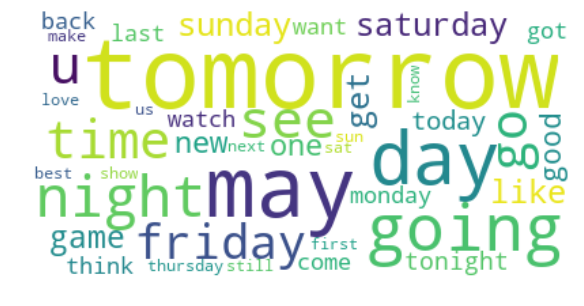

In [12]:
# Create and generate a word cloud image:
wc = WordCloud(stopwords=stopwords, background_color="white", max_words=40).generate_from_frequencies(total_counter)

plt.figure(figsize=(12,5))
# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3>Graph showing the exact Frequency of appearance for the Most Frequent Words</h3>

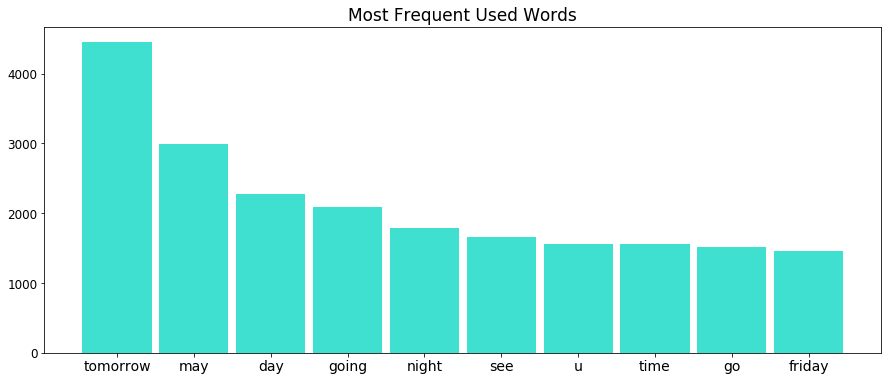

In [13]:
# Choose the names of the bars
words = list(wc.words_.keys())

# Find frequencies
freq = []
for word in words:
    freq.append(total_counter[word])
    
#np array
y_pos = np.arange(len(words[:10]))

#size
plt.figure(figsize=(15,6))
plt.title("Most Frequent Used Words", fontsize=17)

# Create bars
plt.bar(y_pos, freq[:10], color='turquoise', width=0.9)
 
# Create names on the x-axis
plt.xticks(y_pos, words, color='black', fontsize=14)
plt.yticks(color='black', fontsize=12)
plt.show()

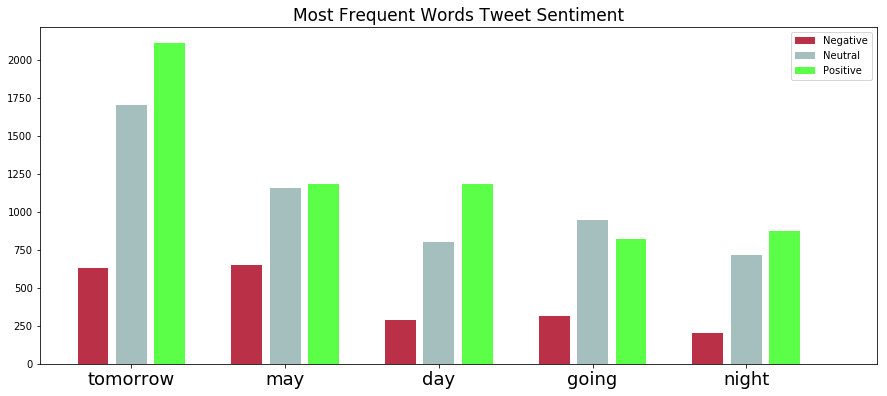

In [14]:
#FiveMostFrequent
FiveMostFrequent = list(wc.words_.keys())[:5]

# Create bars
barWidth = 0.8
bars1 = []
bars2 = []
bars3 = []
for word in FiveMostFrequent:
    bars1.append(negative_counter[word])
    bars2.append(neutral_counter[word])
    bars3.append(positive_counter[word])
    
bars4 = bars1 + bars2 + bars3
 
# The X position of bars
r1 = [1,5,9,13,17]
r2 = [2,6,10,14,18]
r3 = [3,7,11,15,19]
sep =[4,8,12,16,20]
r4 = r1 + r2 + r3 + sep

# plot size
plt.figure(figsize=(15,6))

# Create barplot
plt.bar(r1, bars1, width = barWidth, color = (0.7,0.1,0.2,0.9), label='Negative')
plt.bar(r2, bars2, width = barWidth, color = (0.3,0.5,0.5,0.5), label='Neutral')
plt.bar(r3, bars3, width = barWidth, color = (0.2,1.0,0.1,0.8), label='Positive')
plt.bar(sep, [0,0,0,0,0], width = barWidth, color = (0.0,0.0,0.0,0.0))
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend()
plt.title("Most Frequent Words Tweet Sentiment", fontsize=17) 
# Text below each barplot with a rotation at 90°
plt.xticks([4*r + barWidth*2.5 for r in range(len(FiveMostFrequent))], FiveMostFrequent, fontsize=18)
 
# Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)
 
# Show graphic
plt.show()

<h3>Below we have the most Positive words</h3><br>
<b>Not only measured by appearances on positive tweets </b>, but the <b>ratio between positive and negative</b> is very high<br>
Which means that they appeared exponentially more times in positive tweets rather than negative ones.<br>
That way we have a more representative result.

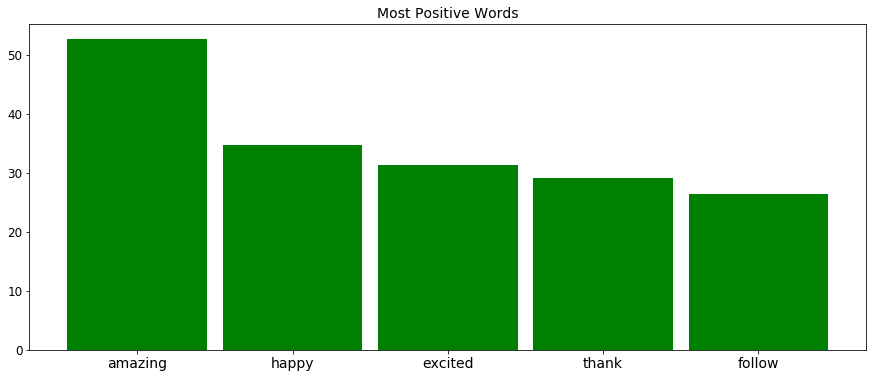

In [15]:
UsedWords = [word for word in total_counter.keys() if total_counter[word] >= 100]
UsedWords.sort(key=lambda word: (positive_counter[word]/negative_counter[word]), reverse=True)
HighRatioWords = UsedWords[:5]

# Find ratio
ratio = []
for word in HighRatioWords:
    ratio.append(positive_counter[word]/negative_counter[word])
#np array
y_pos = np.arange(len(HighRatioWords))
#size
plt.figure(figsize=(15,6))

# Create bars
plt.bar(y_pos, ratio, color='green', width=0.9)
 
# Create names on the x-axis
plt.title('Most Positive Words', fontsize=14)
plt.xticks(y_pos, HighRatioWords, color='black', fontsize=14)
plt.yticks(color='black', fontsize=12)
plt.show()

<h2>OBSERVATION !</h2>
<h4>As we see, "tomorrow" has the most appearances in positive tweets, but the ones that are used purely on positive tweets are "amazing", "happy", "excited" ... </h4>


<h3>Same way as above now we have the most Negative words</h3><br>
<b>Not only measured by appearances on negative tweets </b>, but the <b>ratio between positive and negative</b> is very low<br>
Which means that they appeared exponentially more times in negative tweets rather than positive ones.<br>
That way we have a more representative result.

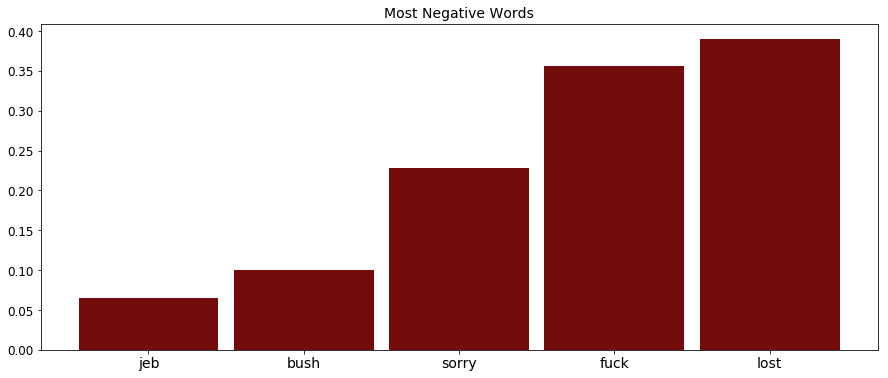

In [16]:
UsedWords = [word for word in total_counter.keys() if total_counter[word] >= 100]
UsedWords.sort(key=lambda word: (positive_counter[word]/negative_counter[word]))
LowRatioWords = UsedWords[:5]

# Find ratio
ratio = []
for word in LowRatioWords:
    ratio.append(positive_counter[word]/negative_counter[word])
#np array
y_pos = np.arange(len(LowRatioWords))
#size
plt.figure(figsize=(15,6))

# Create bars
plt.bar(y_pos, ratio, color='#750c0c', width=0.9)
 
# Create names on the x-axis
plt.title('Most Negative Words', fontsize=14)
plt.xticks(y_pos, LowRatioWords, color='black', fontsize=14)
plt.yticks(color='black', fontsize=12)
plt.show()

<br>
<h1><center>Vectorization</center></h1>
<br>
<h3>1. Bag Of Words</h3>
<p>Create bow and store it with pickle. Using the list with the actual tweets</p>

<b>Run this only if you want to do the vectorization</b><br>
Carefull you will have to store it later!!!


In [44]:
from sklearn.feature_extraction.text import CountVectorizer

#vectorization
bow_vectorizer = CountVectorizer(max_features=1000) 
bow_xtrain = bow_vectorizer.fit_transform(train_data['Tweet'])  #TWEETS : a list with the actual tweets

<b>SAVE</b><br>
Run this only if you excecuted the above cell and you want to save the vector

In [6]:
#store bow using pickle
filename = 'bag_of_words.sav'
pickle.dump(bow_xtrain, open(filename, 'wb'))

<b>LOAD</b><br>
Run this only if you have already stored the bag of words and you wish to load it instead of computing it.

In [127]:
#load stored model
filename = 'bag_of_words.sav'
bow_xtrain = pickle.load(open(filename, 'rb'))

<br><h3>2. TF-IDF</h3>

<b>Run this only if you want to do the vectorization</b><br>
Carefull you will have to store it later!!!

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000) 
tfidf = tfidf_vectorizer.fit_transform(train_data['Tweet'])  #TWEETS : a list with the actual tweets

<b>SAVE</b><br>
Run this only if you excecuted the above cell and you want to save the vector.

In [19]:
#store bow using pickle
filename = 'tf_idf.sav'
pickle.dump(tfidf, open(filename, 'wb'))

<b>LOAD</b><br>
Run this only if you have already stored the bag of words</b> and you wish to load it instead of computing it.

In [128]:
#load stored model
filename = 'tf_idf.sav'
tfidf = pickle.load(open(filename, 'rb'))

<br><h3>3. Word Embeddings</h3>
Using: <br>
1. Lower Case tweets<br>
2. Tokenized tweets<br>

In [196]:
from gensim.models import Word2Vec

w2v_features = 300

In [197]:
%%capture
model_w2v = Word2Vec(
            lowercase_tweets,
            size=w2v_features, # desired no. of features/independent variables
            window=5, # context window size
            min_count=3,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            alpha = 0.02,
            negative = 10, # for negative sampling
            workers = 8,
            seed = 34) 

model_w2v.train(lowercase_tweets, total_examples= len(lowercase_tweets), epochs=40)

<b>Why did we give as input the lowercase tweets?</b><br>
Well this is the input data that achieved the highest accuracy.<br>
To get there we tested a lot of things.<br>
<ol>
<li>First of all we trained w2v on the raw data, which had some side effects, since the capital words and punctuation gave lot of variation to a single word.
<li>Used the cleaned from stop words, but again we could do better. Maybe because we tokenized the tweets with the tweet tokenizer, there is some importance on "!", "...", ":-)" etc.
<li>And finally the stemmed words, who we thought that would work the best.
</ol>
<br>So there are thoughts that maybe because of the little data we have, every info available is important.<br>

<b>SAVE</b><br>
Run this only if you excecuted the above cell and you want to save the vector.

In [46]:
#store bow using pickle
filename = 'word_embed_' + str(w2v_features) + '.sav'
pickle.dump(model_w2v, open(filename, 'wb'))

<b>LOAD</b><br>
Else Run this if you have already stored the word embeddings to load it instead of computing it.

In [200]:
#load stored model with 300 features
filename = 'word_embed_300.sav'
model_w2v = pickle.load(open(filename, 'rb'))

Now we trained model for epochs and it is ready.<br>
Let's play with our trained model and see some results.

In [58]:
model_w2v.wv.most_similar(positive='trump')

/home/fanarosss/Programms/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.8907683491706848),
 ('front-runner', 0.48988473415374756),
 ("trump's", 0.441070020198822),
 ('jeb', 0.4356135129928589),
 ("bush's", 0.434678852558136),
 ('presidential', 0.43391573429107666),
 ('@gop', 0.421142578125),
 ('@jebbush', 0.411207377910614),
 ('backward', 0.41021525859832764),
 ('inevitably', 0.3989199101924896)]

As we see those are the words that are seen with trump and developed a semantic relationship.

<h3>TSNE graphs below</h3>
Function tsne_plot call for a subset of our model, our whole word2vec is quite dense to visualize it

In [148]:
from sklearn.manifold import TSNE

def tsne_plot(model, w2v):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, val in model:
        tokens.append(w2v.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15,6)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/fanarosss/Programms/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



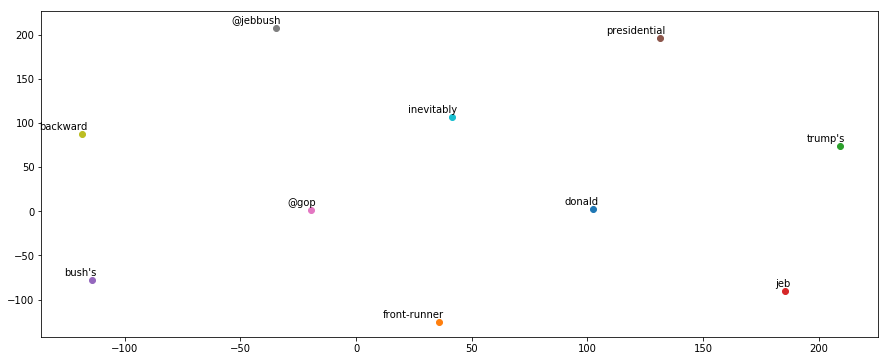

In [152]:
tsne_plot(model_w2v.wv.most_similar(positive='trump'), model_w2v)

<br>
<center><h1>Classification</h1></center><br>
<h2>Using SVΜ classifier</h2><br>

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

n_estimators=20
workers=4

<h3>1. Bag Of Words</h3>

<h4>Split the train set, and apply SVC:</h4>

In [27]:
%%capture
X_train, X_test, Y_train, Y_test = train_test_split(bow_xtrain, train_data['Value'], test_size = 0.20)

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

<p><b>Prediction</b></p>

In [28]:
Y_pred = svclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred) 
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.53      0.38      0.44       862
     neutral       0.62      0.78      0.69      2410
    positive       0.74      0.61      0.67      2320

   micro avg       0.65      0.65      0.65      5592
   macro avg       0.63      0.59      0.60      5592
weighted avg       0.65      0.65      0.64      5592



0.6493204577968527

<h3>2. TFIDF</h3>

<h4>Split the train set, and apply SVC:</h4>

In [31]:
%%capture
X_train, X_test, Y_train, Y_test = train_test_split(tfidf, train_data['Value'], test_size = 0.20) 

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [32]:
Y_pred = svclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred) 
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.55      0.33      0.41       874
     neutral       0.62      0.80      0.70      2470
    positive       0.72      0.61      0.66      2248

   micro avg       0.65      0.65      0.65      5592
   macro avg       0.63      0.58      0.59      5592
weighted avg       0.65      0.65      0.64      5592



0.6469957081545065

<h3>3. Word Embeddings</h3><br>
Since we can't pass the word2key vector directly in svclassifier due to multiple words with multiple features, we need to do the appropriate <u>processing</u>. <br>
With that being said, what we are going to do, is to take the <b>mean</b> of every word vector and produce a "tweet vector" with the same number of features plus whatever we judge necessary, ex. Valence.

<h4>Vector Processor: </h4>

In [218]:
%%capture
extra_features = 6

def w2v_mean(model, tweets):
    w2v_train = np.zeros((len(tweets),w2v_features+extra_features))
    i = 0
    for tweet in tweets:
        tweet_mean = []
        valences= [[],[],[]]
        Sx = [0,0,0]
        Sxx = [0,0,0]
        mean = [0,0,0]
        sdeviation = [0,0,0]
        n = [1,1,1]
        minv = [0,0,0]
        maxv = [0,0,0]
        for word in tweet:
            if word in model.wv.vocab:
                tweet_mean.append(model.wv[word])
            else:
                tweet_mean.append(np.zeros((w2v_features))) 
            #Affin Lexica
            if word in affin_lexica.keys():
                valences[0].append(affin_lexica[word][0])
                Sx[0] += affin_lexica[word][0]
                Sxx[0] += affin_lexica[word][0]**2
                n[0] +=1
            #Tweeter Lexica
            if word in tweeter_lexica.keys():
                valences[1].append(tweeter_lexica[word][0])
                Sx[1] += tweeter_lexica[word][0]
                Sxx[1] += tweeter_lexica[word][0]**2
                n[1] +=1
            #Generic Lexica
            if word in generic_lexica.keys():
                valences[2].append(generic_lexica[word][0])
                Sx[2] += generic_lexica[word][0]
                Sxx[2] += generic_lexica[word][0]**2
                n[2] +=1 
        if tweet:
            #Compute Statistical Features
            for lex in range (0,3):
                mean[lex] = Sx[lex]/n[lex]
                sdeviation[lex] = ((Sxx[lex] - Sx[lex]**2)/n[lex])**(1/2)
                
            w2v_train[i] = np.append(np.average(np.array(tweet_mean), axis = 0), 
                                     np.array([mean[0], mean[1], mean[2], 
                                               sdeviation[0], sdeviation[1], sdeviation[2]]))
        else:
            w2v_train[i] = np.random.randn((w2v_features+extra_features))
        i+=1;

    return w2v_train

<b>a)  Testing the SVC on word embeddings with 300 features</b><br>

<h4>Split the train set, and apply SVC:</h4>

In [222]:
%%capture
X_train, Y_train = w2v_mean(model_w2v, lowercase_tweets), train_data['Value']

X_test = w2v_mean(model_w2v, test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

<h4>Classifier and predictions:</h4>

In [223]:
Y_pred = svclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.65      0.52      0.58      3972
     neutral       0.63      0.66      0.64      5937
    positive       0.50      0.63      0.56      2375

   micro avg       0.61      0.61      0.61     12284
   macro avg       0.59      0.60      0.59     12284
weighted avg       0.61      0.61      0.61     12284



0.6052588733311625

<b>b) Testing the SVC on word embeddings with lesser features</b><br><br>
<b>LOAD</b> embeddings with 100 features

In [125]:
#load stored model with 100 features
filename = 'word_embed_100.sav'
model_w2v = pickle.load(open(filename, 'rb'))

<h4>Split the train set, and apply SVC:</h4>

In [85]:
%%capture
w2v_features = 100

X_train, Y_train = w2v_mean(model_w2v, lowercase_tweets), train_data['Value']

X_test = w2v_mean(model_w2v, test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

<h4>Classifier and predictions:</h4>

In [86]:
Y_pred = svclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.50      0.33      0.39       897
     neutral       0.61      0.73      0.66      2429
    positive       0.68      0.63      0.65      2266

   micro avg       0.62      0.62      0.62      5592
   macro avg       0.60      0.56      0.57      5592
weighted avg       0.62      0.62      0.62      5592



0.6235693848354793

The precision with fewer features (100 instead of 300) is obviously worse.<br>
<b>-> More features mean larger accuracy</b>

<b>c) Word embeddings + SVC <u>observations and conclusions</u>: </b><br><br>
As we see, with the word embeddings and SVC classifier, we achieved a percision of around 67-68%.<br>
To get to that percision, we tested a lot of things.<br>
As we explained earlier, we give as input to the training the tweet_tokenized and lowercased tweets and saw the accuracy to rise 5%.<br>
For further more increase, we expanded the feature vector to 300 + 6, where those 6 values are taken by the dictionaries.<br>
The best combination of lexicas was using the:<br> 
<ol>
    <li> affin lexica which is the more general,
    <li> the tweet lexica, specified on tweet language such as hashtags, emojis and tweet slang,
    <li> generic lexica.
</ol>
With this combination we saw a futher increase of 4-5% overall.<br><br>
We tested lot of other things that didn't work such as:<br>
<ul>
    <li>Using stemmed tweets for training and input to w2v.
    <li>Using extra features such as minimum and maximum valences.
    <li>K least positive words - K most positive words.
    <li><p>Computing the "derivative" of the function that was draw by the valence of every word in the tweet. It was a sum which was<br>  -increased when the "current_valence greater than previous_valence" and <br>  -decreased when "current_valence less than previous_valence".</p>
    <li>Applied L2 and L1 normalization.
</ul>


<h3>4. Conclusion for SVC</h3>
<br>
Below we have a graph showing the scaling between number of features and dictionaries<br>


In [119]:
import plotly.plotly as ply
import plotly.graph_objs as go

In [124]:
#Graph showing the Improvement between the number of features, and the extra lexica features.

#w2v 50 features with lexicas 0.6530758226037195
#w2v 50 features without lexicas 0.5899499284692418
#w2v 100 features with lexicas 0.6638054363376252
#w2v 100 features without lexicas 0.6062231759656652
#w2v 200 features with lexicas 0.6727467811158798
#w2v 200 features without lexicas 0.6237482117310443
#w2v 300 features with lexicas 0.6722103004291845
#w2v 100 features without lexicas 0.6062231759656652

#load w2v scaling plot from my account at plotly
x = [50, 100, 200, 300]
x_rev = [0.55, 0.60, 0.65, 0.7]

# Line 1
y1 = [0.653, 0.663, 0.672, 0.672]

# Line 2
y2 = [0.589, 0.606, 0.623, 0.626]

trace1 = go.Scatter(
    x=x,
    y=y1,
    line=dict(color='rgb(205, 12, 24)',
             width=4),
    mode='lines',
    name='With Lexicas',
)
trace2 = go.Scatter(
    x=x,
    y=y2,
    line=dict(color='rgb(0,176,246)',
             width=4),
    mode='lines',
    name='Without Lexicas',
)

data = [trace1, trace2]

layout = go.Layout(
    paper_bgcolor='rgb(255,255,255)',
    plot_bgcolor='rgb(229,229,229)',
    xaxis=dict(
        gridcolor='rgb(255,255,255)',
        range=[50,300],
        showgrid=True,
        showline=False,
        showticklabels=True,
        tickcolor='rgb(127,127,127)',
        ticks='outside',
        zeroline=False
    ),
    yaxis=dict(
        gridcolor='rgb(255,255,255)',
        showgrid=True,
        showline=False,
        showticklabels=True,
        tickcolor='rgb(127,127,127)',
        ticks='outside',
        zeroline=False
    ),
)
fig = go.Figure(data=data, layout=layout)
#Load chart from my plot.ly account
ply.iplot(fig, filename= 'w2v_scaling')

#use this when the chart is finalized
#from IPython.display import IFrame
#IFrame(src='./w2v_scaling.html', width=950, height=600)

<h2>Using KNN classifier</h2>

In [20]:
from sklearn.neighbors import KNeighborsClassifier

<h3>1. Bag of words</h3>

In [131]:
%%capture
X_train, X_test, Y_train, Y_test = train_test_split(bow_xtrain, train_data['Value'], test_size = 0.20)

knnclassifier = KNeighborsClassifier(n_neighbors = 10,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [132]:
Y_pred = knnclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.36      0.05      0.09       883
     neutral       0.47      0.86      0.61      2427
    positive       0.57      0.25      0.35      2282

   micro avg       0.49      0.49      0.49      5592
   macro avg       0.47      0.39      0.35      5592
weighted avg       0.49      0.49      0.42      5592



0.4851573676680973

<h3>2. TF IDF</h3>

In [135]:
%%capture
X_train, X_test, Y_train, Y_test = train_test_split(tfidf, train_data['Value'], test_size = 0.20)

knnclassifier = KNeighborsClassifier(n_neighbors = 10,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [136]:
Y_pred = knnclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.50      0.12      0.19       874
     neutral       0.51      0.85      0.64      2427
    positive       0.67      0.38      0.49      2291

   micro avg       0.54      0.54      0.54      5592
   macro avg       0.56      0.45      0.44      5592
weighted avg       0.57      0.54      0.51      5592



0.5448855507868383

<h3>3. Word Embeddings</h3>

In [220]:
%%capture
X_train = w2v_mean(model_w2v, lowercase_tweets)
Y_train = train_data['Value']

X_test = w2v_mean(model_w2v, test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 10,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [221]:
Y_pred = knnclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.67      0.44      0.53      3972
     neutral       0.60      0.67      0.63      5937
    positive       0.45      0.59      0.51      2375

   micro avg       0.58      0.58      0.58     12284
   macro avg       0.57      0.57      0.56     12284
weighted avg       0.60      0.58      0.58     12284



0.579290133507001

<h3>4. Conclusions about KNN:</h3><br>
KNNs accuracy is lower than SVC, and that is due to the fact that KNN is a non-parametric and lazy learning algorithm.<br>
A very important characteristic about KNN is the cursing of <b>dimensionality.</b><br>
The algorithm performs better with lesser features rather than a large amount. In order to have lot of features, you have to have a lot of data (which we do not have).
So let's see how KNN performs with a small amount of features at word embeddings.<br>

In [225]:
w2v_features = 100

#load stored model with 100 features
filename = 'word_embed_100.sav'
model_w2v = pickle.load(open(filename, 'rb'))

X_train, Y_train = w2v_mean(model_w2v, lowercase_tweets), train_data['Value']

X_test = w2v_mean(model_w2v, test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 10,
                                    algorithm='auto',
                                    metric='minkowski',
                                    p=2,
                                    n_jobs=-1)
knnclassifier.fit(X_train, Y_train)

Y_pred = knnclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

/home/fanarosss/Programms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: ComplexWarning:

Casting complex values to real discards the imaginary part



              precision    recall  f1-score   support

    negative       0.65      0.48      0.55      3972
     neutral       0.62      0.63      0.62      5937
    positive       0.43      0.61      0.51      2375

   micro avg       0.58      0.58      0.58     12284
   macro avg       0.57      0.57      0.56     12284
weighted avg       0.59      0.58      0.58     12284



0.5758710517746662

As we can see the accuracy did not grow, but it stayed roughly the same with both 100 and 300 features.<br>
Consider that with SVM there was a great difference between those two<br>
<b>That means, that maybe above 300 features KNN will start overfitting with the data we have.</b><br>

<br><center><h3>Comparing KNN and SVM : </h3></center><br>

In [147]:
x = ['Bow', 'Tf-idf', 'Embeddings']
x_rev = [0.45, 0.50, 0.55, 0.60, 0.65, 0.7]

# Line 1
y1 = [0.48, 0.545, 0.64]

# Line 2
y2 = [0.60, 0.64, 0.67]

trace1 = go.Scatter(
    x=x,
    y=y1,
    name='KNN',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)
trace2 = go.Scatter(
    x=x,
    y=y2,
    name='SVC',
    line = dict(
        color = ('rgb(37, 102, 211)'),
        width = 4)
)

data = [trace1, trace2]

# Edit the layout
layout = dict(title = 'How Vectorization affects classification',
              xaxis = dict(title = 'Vectorization Method'),
              yaxis = dict(title = 'Accuracy'),
              )

fig = go.Figure(data=data, layout=layout)
#Load chart from my plot.ly account
ply.iplot(fig, filename= 'vectorization_scaling')

<br><h3>Extra observations with pretrained embeddings</h3>
<br><b>Finally,</b> let's use the pretrained embeddings and see how they do, in comparison with our implementation.

In [227]:
w2v_features = 300
embeddings_dict = {}

f = open('datastories.twitter.300d.txt', "r", encoding="utf-8")

for i, line in enumerate(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefs

Special function made to adjust the w2v without lexicas, to see how the pretrained embeddings behave.

In [228]:
def w2v_avg(model, tweets):
    w2v_train = np.zeros((len(tweets),w2v_features+extra_features))
    i = 0
    for tweet in tweets:
        tweet_mean = []
        valences= [[],[],[]]
        Sx = [0,0,0]
        Sxx = [0,0,0]
        mean = [0,0,0]
        sdeviation = [0,0,0]
        n = [1,1,1]
        minv = [0,0,0]
        maxv = [0,0,0]
        for word in tweet:
            if word in model:
                tweet_mean.append(model[word])
            else:
                tweet_mean.append(np.zeros((w2v_features))) 
            #Affin Lexica
            if word in affin_lexica.keys():
                valences[0].append(affin_lexica[word][0])
                Sx[0] += affin_lexica[word][0]
                Sxx[0] += affin_lexica[word][0]**2
                n[0] +=1
            #Tweeter Lexica
            if word in tweeter_lexica.keys():
                valences[1].append(tweeter_lexica[word][0])
                Sx[1] += tweeter_lexica[word][0]
                Sxx[1] += tweeter_lexica[word][0]**2
                n[1] +=1
            #Generic Lexica
            if word in generic_lexica.keys():
                valences[2].append(generic_lexica[word][0])
                Sx[2] += generic_lexica[word][0]
                Sxx[2] += generic_lexica[word][0]**2
                n[2] +=1 
        if tweet:
            #Compute Statistical Features
            for lex in range (0,3):
                mean[lex] = Sx[lex]/n[lex]
                sdeviation[lex] = ((Sxx[lex] - Sx[lex]**2)/n[lex])**(1/2)
                
            w2v_train[i] = np.append(np.mean(np.array(tweet_mean), axis = 0), 
                                     np.array([mean[0], mean[1], mean[2], 
                                               sdeviation[0], sdeviation[1], sdeviation[2]]))
        else:
            w2v_train[i] = np.random.randn((w2v_features+extra_features))
        i+=1;

    return w2v_train

Classsify with <b>SVM</b>:

In [229]:
%%capture
X_train, Y_train = w2v_avg(embeddings_dict, clean_tweets), train_data['Value']

X_test = w2v_avg(embeddings_dict, test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

<b>Predictions:</b>

In [230]:
Y_pred = svclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.60      0.60      0.60      3972
     neutral       0.61      0.70      0.66      5937
    positive       0.64      0.40      0.49      2375

   micro avg       0.61      0.61      0.61     12284
   macro avg       0.62      0.57      0.58     12284
weighted avg       0.61      0.61      0.61     12284



0.6115271898404429